In [1]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display

In [2]:
filename='data/UrbanSound8K/audio/fold1/7061-6-0-0.wav'

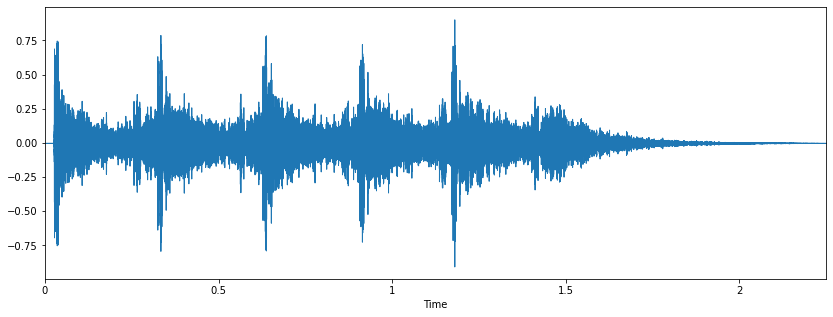

In [3]:
plt.figure(figsize=(14,5))
librosa_audio_data,librosa_sample_rate=librosa.load(filename)
librosa.display.waveplot(librosa_audio_data,sr=librosa_sample_rate)
ipd.Audio(filename)

In [4]:
from scipy.io import wavfile as wav

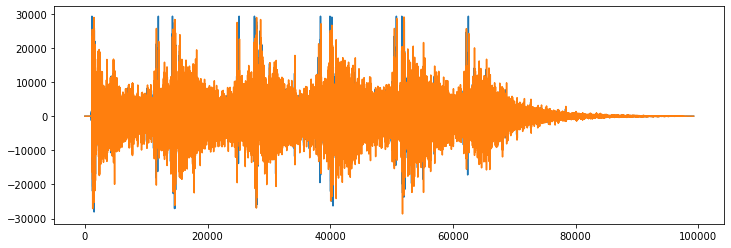

In [5]:
wave_sample_rate, wave_audio = wav.read(filename)

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

# Extract feature

In [6]:
import pandas as pd

audio_dataset_path='data/UrbanSound8K/audio/'
metadata=pd.read_csv('data/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [7]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [8]:
import numpy as np
from tqdm import tqdm
import os

### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    data=features_extractor(file_name)
    extracted_features.append([data,"noise"])

for i in os.listdir(os.path.join("data", "clean_train")):
    file_name = os.path.join("data", "clean_train", i)
    data=features_extractor(file_name)
    extracted_features.append([data,"clean"])

3554it [02:17, 23.60it/s]E:\OpenCV\Sign Language\tfod\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
8323it [06:34, 25.31it/s]E:\OpenCV\Sign Language\tfod\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
8327it [06:34, 28.34it/s]E:\OpenCV\Sign Language\tfod\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]
8732it [06:54, 21.05it/s]


In [42]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
len(extracted_features_df)

31807

In [43]:
extracted_features_df = extracted_features_df.sample(frac=1).reset_index(drop=True)
extracted_features_df.head()

,feature,class
0,"[-132.09993, 103.1028, -20.494783, 40.094696, ...",noise
1,"[-427.79974, 90.52574, -7.0708323, 29.457516, ...",clean
2,"[-340.85706, 128.36781, -13.814865, 57.585346,...",clean
3,"[-367.51047, 143.89073, -7.9653697, 40.998653,...",clean
4,"[-391.29282, 87.73315, -11.884835, 45.00353, -...",clean


In [40]:
clean_class = extracted_features_df[extracted_features_df['class'] == 'clean']
len(clean_class)

23075

In [41]:
noise_class = extracted_features_df[extracted_features_df['class'] == 'noise']
len(noise_class)

8732

# Data split

In [44]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [45]:
y=np.array(pd.get_dummies(y))

In [46]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [47]:
y_train[:10]

array([[1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

# Tensorflow

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [49]:
num_labels=y.shape[1]

In [50]:
model=Sequential()

###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               4100      
                                                                 
 activation_4 (Activation)   (None, 100)               0         
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               20200     
                                                                 
 activation_5 (Activation)   (None, 200)               0         
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 100)              

In [51]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [52]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint

num_epochs = 10
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/noise_classification.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)

Epoch 1/10
787/796 [============================>.] - ETA: 0s - loss: 1.5180 - accuracy: 0.8843
Epoch 1: val_loss improved from inf to 0.04234, saving model to saved_models\noise_classification.hdf5
796/796 [==============================] - 5s 6ms/step - loss: 1.5042 - accuracy: 0.8848 - val_loss: 0.0423 - val_accuracy: 0.9910
Epoch 2/10
788/796 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.9810
Epoch 2: val_loss improved from 0.04234 to 0.00926, saving model to saved_models\noise_classification.hdf5
796/796 [==============================] - 5s 6ms/step - loss: 0.0705 - accuracy: 0.9811 - val_loss: 0.0093 - val_accuracy: 0.9973
Epoch 3/10
791/796 [============================>.] - ETA: 0s - loss: 0.0290 - accuracy: 0.9923
Epoch 3: val_loss improved from 0.00926 to 0.00511, saving model to saved_models\noise_classification.hdf5
796/796 [==============================] - 5s 6ms/step - loss: 0.0290 - accuracy: 0.9923 - val_loss: 0.0051 - val_accuracy: 0.9983
Ep

In [53]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9993712902069092


In [61]:
noisefile = "data/noise_train/AirConditioner_2.wav"
prediction_feature=features_extractor(noisefile)
prediction_feature=prediction_feature.reshape(1,-1)
predict_x= (model.predict(prediction_feature) > 0.8).astype("int32")
print(predict_x)
ipd.Audio(noisefile)

1/1 [==============================] - 0s 13ms/step
[[1 0]]


In [62]:
cleanfile = "data/clean_test/clnsp2.wav"
prediction_feature=features_extractor(cleanfile)
prediction_feature=prediction_feature.reshape(1,-1)
predict_x= (model.predict(prediction_feature) > 0.8).astype("int32")
print(predict_x)
ipd.Audio(cleanfile)

1/1 [==============================] - 0s 14ms/step
[[1 0]]
